###  US Reg Leverage on Spread
Nimrod Cohen, November 2020

In [1]:
## Using Jupter and Spyder\Atom Together
## https://medium.com/@rrfd/cookiecutter-data-science-organize-your-projects-atom-and-jupyter-2be7862f487e
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
# my functions and oter iports
import src.config as config
from src.config import my_pd as pd
from src.config import my_plt as plt
from src.config import my_colors as colors
file_date = config.file_date
from src.funct.ncDate import period
from src.funct.ncPlot import multi_save, add_Rec, plot1ax, plot2axs
from src.funct import ncStat

# very importent - get Project Main Path
project_path = config.project_path
current_NB_path = 'src/models/'
import os
os.chdir(project_path)

import numpy as np
import statsmodels as st
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# set plot parameters
#import matplotlib.colors as mcolors
#colors = list(mcolors.BASE_COLORS) # mcolors.TABLEAU_COLORS

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

### Get Processed Data

In [4]:
import src.data.read_from_Fred as fred
path='data/processed/'
df_US   = fred.Get_data(path)
#list(df_US.columns)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


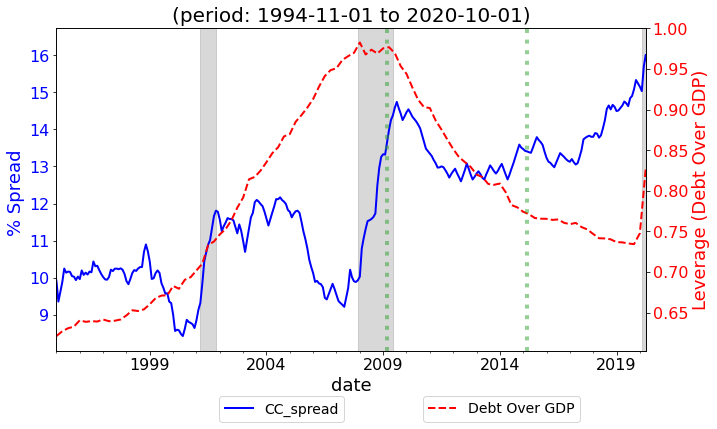

In [5]:
#with plt.xkcd():
if True:
    colY=['CC_spread']
    colX=['Debt Over GDP']
    start = str(df_US[colY].dropna().index[0].date())    
    end = str(df_US[colY].dropna().index[-1].date())    
    mask = period(df_US.index,start=start)#start = '2015-02-01'

    ax1,ax2 = plot2axs(columns1=colY,columns2=colX,
                       ylabel1 ='% Spread ' , ylabel2='Leverage (Debt Over GDP)',
                       df=df_US.loc[mask,colY+colX],
                       markers=['',''],colors=['b','r'],linestyles=['-','--'],
                       bbox1=(0.5, -0.12),bbox2=(0.9, -0.12))    
    add_Rec(ax1,df_US,'USRECM')
    ax2.set_title('(period: '+start+' to '+end+')')
    ax2.axvline(x='2009-03-31' ,linewidth=4, color=colors[2],linestyle=':',alpha=0.5)
    ax2.axvline(x='2015-03-31' ,linewidth=4, color=colors[2],linestyle=':',alpha=0.5)

In [6]:
to_Q_reg=df_US[colY+colX].dropna()
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95] 
ols = ncStat.ols_fit(x_name=colX[0],y_name=colY[0],df=to_Q_reg)
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              CC_spread   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     8.961
Date:                Sun, 29 Nov 2020   Prob (F-statistic):            0.00347
Time:                        19:22:57   Log-Likelihood:                -200.28
No. Observations:                 102   AIC:                             404.6
Df Residuals:                     100   BIC:                             409.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.0668      1.291      6.247      0.000       5.505      10.629
Debt Over GDP     4.8381      1.616      2.994      0.003       1.632       8.045
==============================================================================
Omnibus:                        3.549   Durbin-Watson:                   0.045
Prob(Omnibus):                  0.170   Jarque-Bera (JB):                2.024
Skew:                           0.015   Prob(JB):                        0.363
Kurtosis:                       2.311   Cond. No.                         15.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

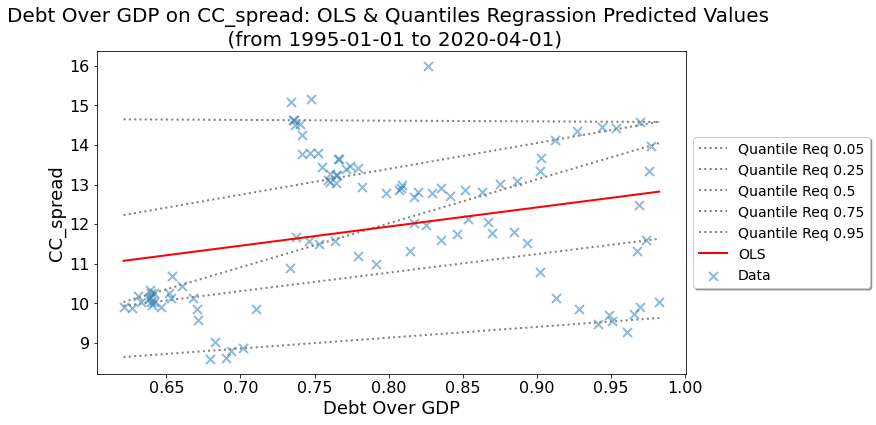

In [7]:
ax = ncStat.regs_plot(x_name=colX[0], y_name=colY[0],df=to_Q_reg)
ax.set_title(colX[0]+' on '+colY[0]+ ': OLS & Quantiles Regrassion Predicted Values \n (from ' + 
             str(to_Q_reg.index[0].date())+' to '+str(to_Q_reg.index[-1].date())+')');

In [8]:
to_Q_reg['lev'] = to_Q_reg['Debt Over GDP']  
to_Q_reg['lev^2'] = to_Q_reg['lev']**2
to_Q_reg['ln(lev)'] = np.log(to_Q_reg['lev'])
to_Q_reg['[ln(lev)]^2'] = to_Q_reg['ln(lev)']**2

In [9]:
Y,X=[],[]
Y.append('CC_spread') # Model 0
X.append(['lev'])
Y.append('CC_spread') # Model 1
X.append(['lev^2'])
Y.append('CC_spread') # Model 2
X.append(['lev','lev^2'])
Y.append('CC_spread') # Model 3
X.append(['ln(lev)'])
Y.append('CC_spread') # Model 4
X.append(['[ln(lev)]^2'])
Y.append('CC_spread') # Model 5
X.append(['ln(lev)','[ln(lev)]^2'])
regressor_order = ['const','lev','lev^2','ln(lev)','[ln(lev)]^2']

In [10]:
# Build Regration spesfication table
from statsmodels.iolib.summary2 import summary_col
info_dict={#'R squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}",
           #'Adj. R-squared' : lambda x: f"{x.rsquared_adj:.2f}",
           'AIC' : lambda x: f"{x.aic:.2f}",
           'BIC' : lambda x: f"{x.bic:.2f}"
          }# %%

In [11]:
results=[]
to_Q_reg = sm.add_constant(to_Q_reg)
for i,Yi in enumerate(Y):
    # Estimate an OLS regression for each set of variables
    results.append(sm.OLS(endog=to_Q_reg[Yi], exog=to_Q_reg[['const']+X[i]], missing='drop').fit())
results_table = summary_col(results=results,model_names=Y, float_format='%0.2f',
                            stars = True, info_dict=info_dict, regressor_order=regressor_order)
results_table.add_title('Table # - OLS Regressions: Spread vs Laverage')
results_table
print(results_table)

                             Table # - OLS Regressions: Spread vs Laverage
                 CC_spread I CC_spread II CC_spread III CC_spread IIII CC_spread IIIII CC_spread IIIIII
-------------------------------------------------------------------------------------------------------
const            8.07***     10.20***     -45.64***     12.93***       12.80***        10.84***        
                 (1.29)      (0.67)       (8.49)        (0.35)         (0.24)          (0.45)          
lev              4.84***                  141.28***                                                    
                 (1.62)                   (21.43)                                                      
lev^2                        2.66**       -85.11***                                                    
                             (1.02)       (13.34)                                                      
ln(lev)                                                 4.27***                        -20.69

In [12]:
Model = 1
print(results[Model].summary())

                            OLS Regression Results                            
Dep. Variable:              CC_spread   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     6.851
Date:                Sun, 29 Nov 2020   Prob (F-statistic):             0.0102
Time:                        19:22:59   Log-Likelihood:                -201.28
No. Observations:                 102   AIC:                             406.6
Df Residuals:                     100   BIC:                             411.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2001      0.672     15.190      0.0

just for simple regression 

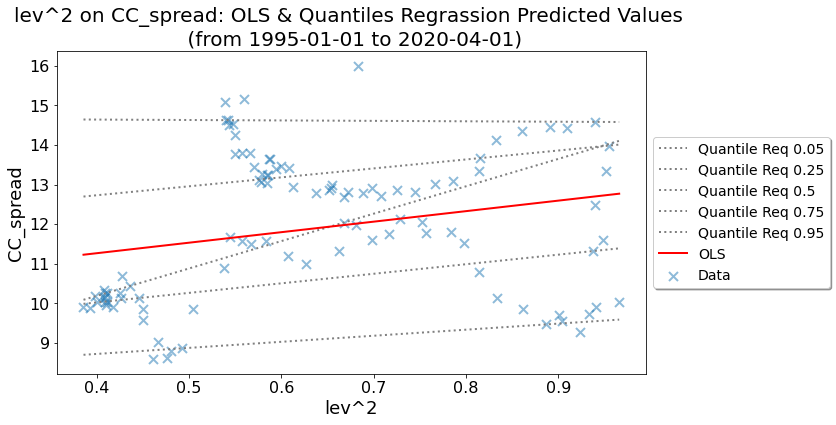

In [13]:
Model = 1
if len(X[Model])>1:
    print('multi varibels reresion')
else:
    ax = ncStat.regs_plot(x_name=X[Model][0], y_name=Y[Model],df=to_Q_reg)
    ax.set_title(X[Model][0]+' on '+Y[Model]+ ': OLS & Quantiles Regrassion Predicted Values \n (from ' + 
                str(to_Q_reg.index[0].date())+' to '+str(to_Q_reg.index[-1].date())+')');

In [14]:
os.chdir(current_NB_path)
###################################################
### IMPORTENT : update Notebook file_name below ###
###################################################
## Print Notebook wo code (inputs)
!jupyter nbconvert 1.1-n-US_reg_leverage_on_spread.ipynb --no-input --no-prompt --to pdf

# to try also https://ipypublish.readthedocs.io/en/latest/ : 
# !nbpublish -f latex_ipypublish_all -pdf file_name.ipynb
# also sphinx and jupinx and more....

os.chdir(project_path)

[NbConvertApp] Converting notebook 1.1-n-US_reg_leverage_on_spread.ipynb to pdf
[NbConvertApp] Writing 92249 bytes to 1.1-n-US_reg_leverage_on_spread.pdf
